# Ethical AI - Fairness self-study exercise

Author: Nina Nowak, Senior Data Scientist at <a href="http://themix.ai/">Combient Mix</a>

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In this notebook we will try to measure and mitigate fairness of a simple classification model using the Python module Fairlearn. You do not need to know how to build machine learning models, but to do the exercise segments you will need some basic knowledge of Python.

To run a cell: press SHIFT+ENTER

Let's start and first install and import basic python modules

In [ ]:
!pip install fairlearn
!pip install ipywidgets

In [ ]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1. Load and inspect the Adult Income dataset

The Adult Income dataset is from the 1994 United States Census Bureau. The task is to predict whether a given individual makes more than $50,000 a year based attributes such as education, hours of work per week, etc.

In [ ]:
# We use the Adult Income Dataset http://archive.ics.uci.edu/ml/datasets/Adult
# Show the first few rows of the dataset
adult = pd.read_csv('https://github.com/nillepu/EthicalAI/raw/main/adult-all.csv',sep=',')
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
# How many rows/observations?
len(adult)

48842

In [ ]:
# basic statistics of the numeric features
adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
# convert $ amounts to log(amount)
adult['capital-gain'] = np.log1p(adult['capital-gain'])
adult['capital-loss'] = np.log1p(adult['capital-loss'])

(0.0, 5000.0)

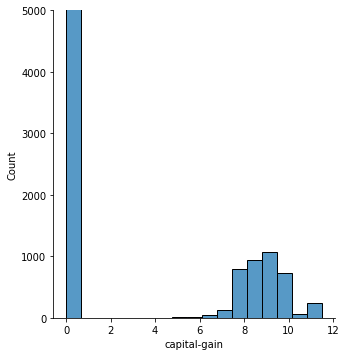

In [ ]:
# show the distribution of the log-amounts
sns.displot(adult["capital-gain"])
plt.ylim([0,5000])

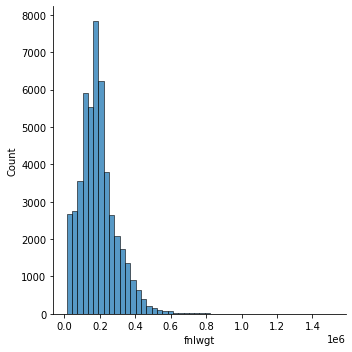

In [ ]:
# fnlwgt = final weight of how much of the population it represents.
sns.displot(adult["fnlwgt"],binwidth=0.03e6)


In [ ]:
# try to plot distributions of other numeric features
#
# your code here

In [ ]:
# look at the categorical features
cat_features = ['workclass','education','marital-status','occupation','relationship','race','gender','native-country']
adult[cat_features].describe().T

,count,unique,top,freq
workclass,48842,9,Private,33906
education,48842,16,HS-grad,15784
marital-status,48842,7,Married-civ-spouse,22379
occupation,48842,15,Prof-specialty,6172
relationship,48842,6,Husband,19716
race,48842,5,White,41762
gender,48842,2,Male,32650
native-country,48842,42,United-States,43832


In [ ]:
# How many people are in each class?
adult.groupby('income')['income'].count()

income
<=50K    37155
>50K     11687
Name: income, dtype: int64

Let's have a look at how many people per protected class have a high income. Is the data we will use to train the algorithm biased?

In [ ]:
incm_by_race = pd.pivot_table(adult, values='workclass', index='race', columns='income', aggfunc='count', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
incm_by_race['high_incm_fraction'] = incm_by_race['>50K']/(incm_by_race['<=50K']+incm_by_race['>50K'])
incm_by_race

income,<=50K,>50K,high_incm_fraction
race,,,
Amer-Indian-Eskimo,415,55,0.117021
Asian-Pac-Islander,1110,409,0.269256
Black,4119,566,0.120811
Other,356,50,0.123153
White,31155,10607,0.253987


The fraction of people with a high income is around twice as large for Whites and Asian-Pac-Islanders compared to all other ethnic groups. So there is a notable racial bias in this data.

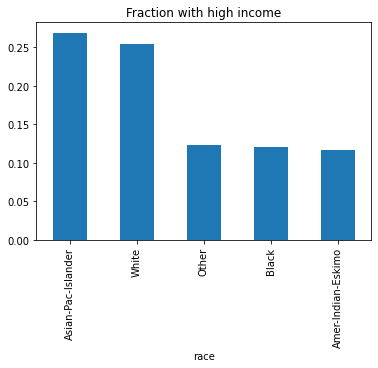

In [ ]:
incm_by_race['high_incm_fraction'].sort_values(ascending=False).plot(kind='bar', title='Fraction with high income')

In [ ]:
incm_by_gender = pd.pivot_table(adult, values='workclass', index='gender', columns='income', aggfunc='count', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
incm_by_gender['high_incm_fraction'] = incm_by_gender['>50K']/(incm_by_gender['<=50K']+incm_by_gender['>50K'])
incm_by_gender

income,<=50K,>50K,high_incm_fraction
gender,,,
Female,14423,1769,0.109251
Male,22732,9918,0.303767


Around 3 times as many men have a high income compared to women. So there is a notable gender bias in this data.

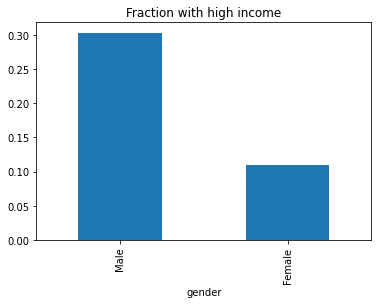

In [ ]:
incm_by_gender['high_incm_fraction'].sort_values(ascending=False).plot(kind='bar', title='Fraction with high income')

In [ ]:
# home country also seems to be a factor
incm_by_cntry = pd.pivot_table(adult, values='workclass', index='native-country', columns='income', aggfunc='count', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
incm_by_cntry['high_incm_fraction'] = incm_by_cntry['>50K']/(incm_by_cntry['<=50K']+incm_by_cntry['>50K'])
incm_by_cntry[incm_by_cntry['<=50K']>50].sort_values('high_incm_fraction',ascending=False)

income,<=50K,>50K,high_incm_fraction
native-country,,,
India,89.0,62.0,0.410596
England,80.0,47.0,0.370079
Japan,60.0,32.0,0.347826
Canada,119.0,63.0,0.346154
Italy,71.0,34.0,0.323810
China,86.0,36.0,0.295082
Philippines,210.0,85.0,0.288136
Germany,148.0,58.0,0.281553
?,637.0,220.0,0.256709


Let's look at correlations between features

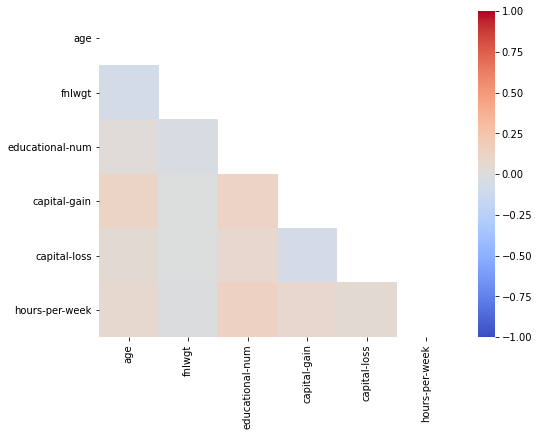

In [ ]:
# Are there any strong correlations between numeric features?
plt.figure(figsize=(8, 6))
matrix = np.triu(adult.corr())
sns.heatmap(adult.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

## 2. Modelling

In [ ]:
# Choose a target variable for prediction: income
# Convert it to a boolean feature. 1=high income, 0=low income
adult['income_cat'] = [1 if x=='>50K' else 0 for x in adult['income']]

In [ ]:
# prepare data for modelling
X = adult.drop('income',axis=1)
X = X.drop('income_cat',axis=1)
y_label = adult.income_cat
X_index = adult.index
feature_names = X.columns

In [ ]:
# encode categorical data: we cannot use classes in text format, so we convert them to integers. Example for the 
# feature gender: 'Female' -> 0, 'Male' -> 1
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for name in cat_features:
    X[name] = le.fit_transform(X[name])

# add the encoded features to the original data to be able to decode the classes later.
adult['gender_enc'] = X['gender']
adult['race_enc'] = X['race']


In [ ]:
# split data into train and test set
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y_label, test_size=0.2, random_state=42)


In [ ]:
# Define the protected attributes
X_train_gender = X_train['gender']
X_train_race = X_train['race']
X_test_gender = X_test['gender']
X_test_race = X_test['race']


In [ ]:
# remove protected attributes before modelling. Remove also native-country.
X_train = X_train.drop('gender', axis=1)
X_train = X_train.drop('race', axis=1)
X_train = X_train.drop('native-country', axis=1)
X_test = X_test.drop('gender', axis=1)
X_test = X_test.drop('race', axis=1)
X_test = X_test.drop('native-country', axis=1)


In [ ]:
feature_names = X_train.columns

In [ ]:
# choose a random forest classifier to predict whether the income is < or > 50k$
np.random.seed(0)
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(class_weight="balanced")
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8630361347118436


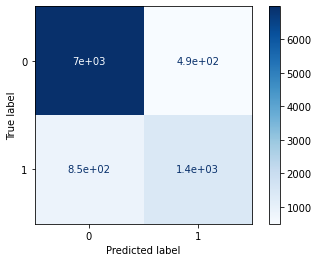

In [ ]:
# Confusion Matrix
cfm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=[0,1],
                                 cmap=plt.cm.Blues)
plt.grid(False)

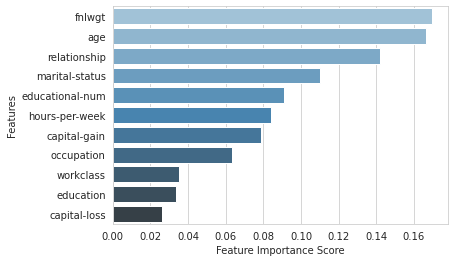

In [ ]:
# Feature importance
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
sns.set_style("whitegrid")
sns.barplot(x=feature_imp, y=feature_imp.index, palette="Blues_d")
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()



## 3. Measure Biases - Fairlearn Dashboard

The Fairlearn Dashboard is an interactive tool to assess the fairness of a model and to compare multiple models in terms of their impacts on different groups of people. It does currently NOT work in Jupyter lab or Google Colab, so if you want to use the dashboard, you need to download the notebook to your laptop and use a local installation of Python, Jupyter Notebook and Fairlearn!

In [ ]:
# Decode race categories
adult.groupby(['race','race_enc'])['race_enc'].count()

race                race_enc
Amer-Indian-Eskimo  0             470
Asian-Pac-Islander  1            1519
Black               2            4685
Other               3             406
White               4           41762
Name: race_enc, dtype: int64

In [ ]:
# Decode gender categories
adult.groupby(['gender','gender_enc'])['gender_enc'].count()

gender  gender_enc
Female  0             16192
Male    1             32650
Name: gender_enc, dtype: int64

In [ ]:
# add protected attributes back to data so we can use Fairlearn Dashboard
sensitive_features = X_test.copy()
sensitive_features['gender'] = X_test_gender
sensitive_features['race'] = X_test_race

In [ ]:
from fairlearn.widget import FairlearnDashboard

Play around with the dashboard. Which groups are negatively impacted by the model?

In [ ]:
# This does currently NOT work in Google Colab or Jupyter lab!
FairlearnDashboard(sensitive_features=sensitive_features[['gender','race']],
                   sensitive_feature_names=['gender','race'],
                   y_true=y_test,
                   y_pred={"initial model": y_pred}) 

FairlearnWidget(value={'true_y': [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0…

## 4. Measure Biases - Statistical Fairness measures

We calculate different statistical fairness measures using both the confusion matrix and the Python module Fairlearn :
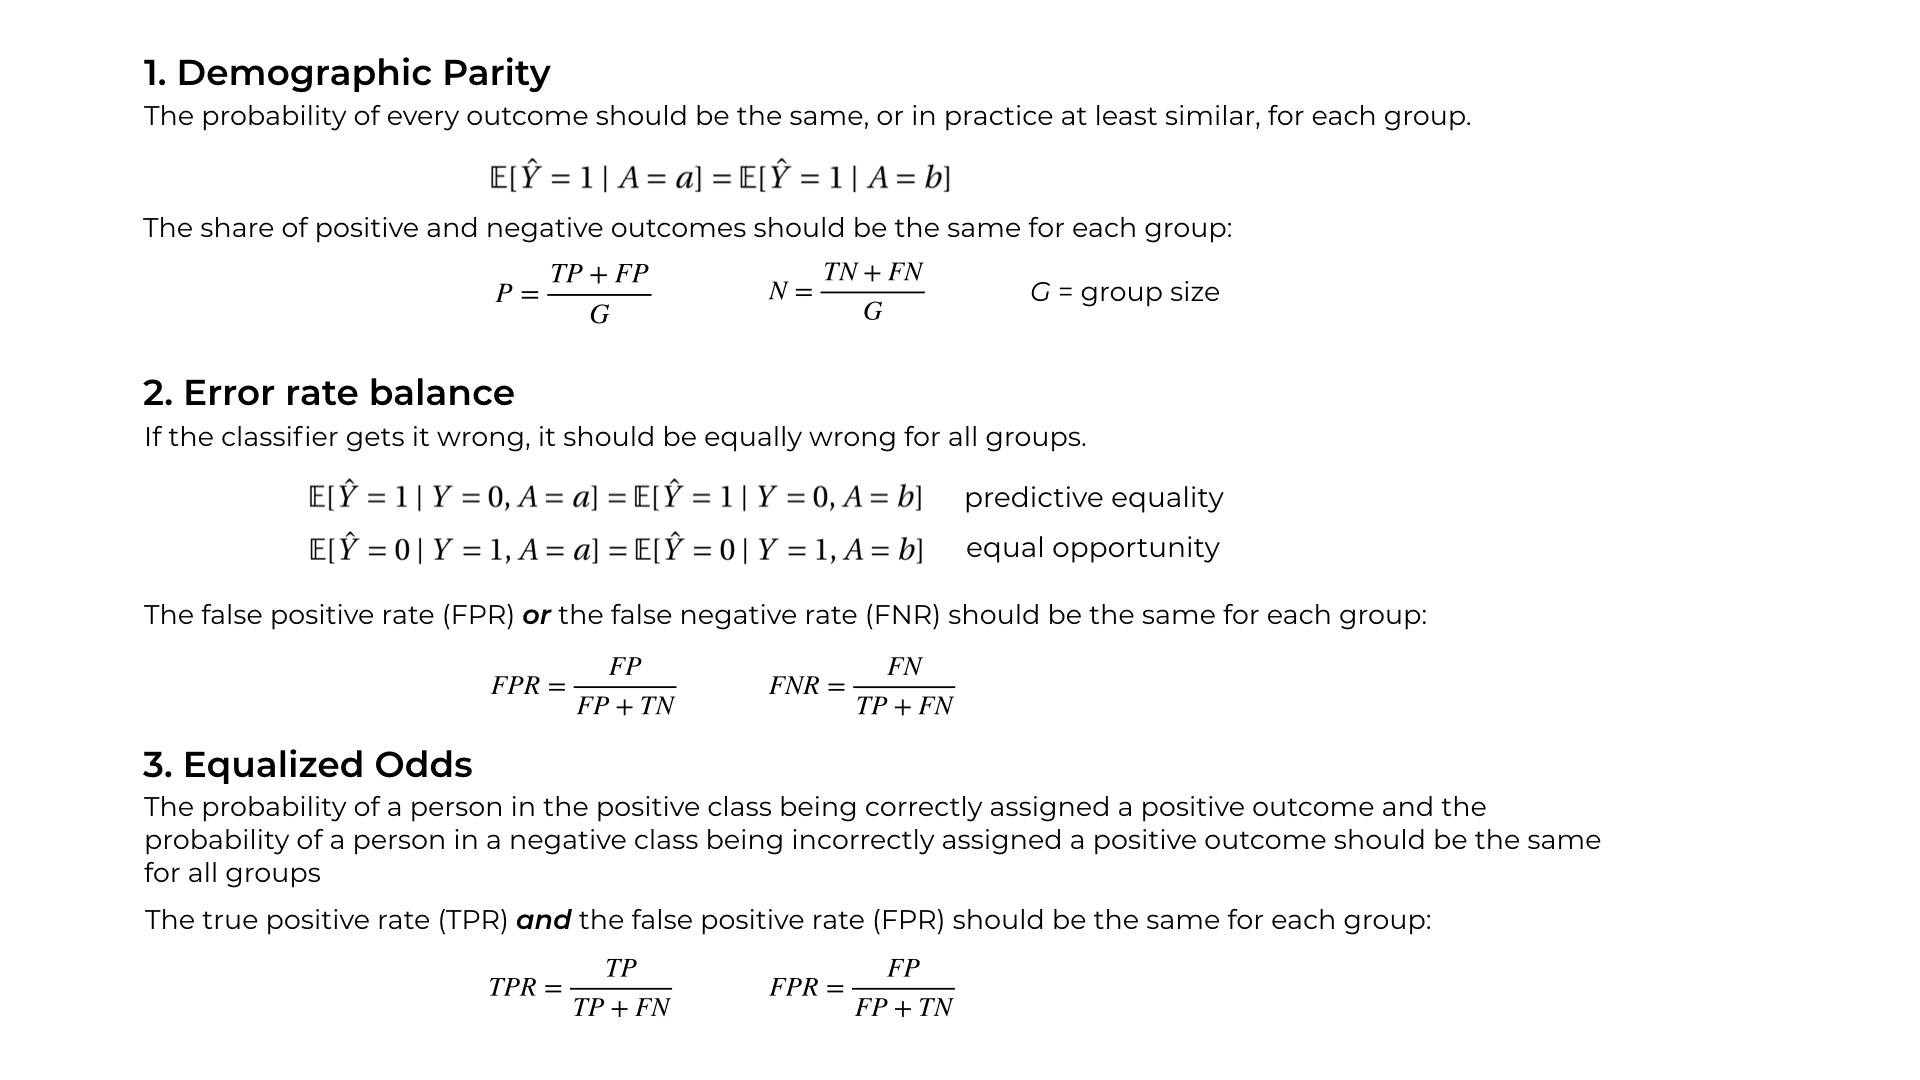

Most measures are calculated using the confusion matrix, so let's recall how it looked like:

In [ ]:
cfm

Predicted,0,1,All
Actual,,,
0,6991,488,7479
1,850,1440,2290
All,7841,1928,9769


### Demographic Parity
Let's look at the share of positive and negative outcomes in general and then for each group

In [ ]:
# Calculate the positives P and negatives N (definition see above) for the entire test sample. Use the
# confusion matrix cfm for your calculations.
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution.
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
pos_tot = (cfm[0][1]+cfm[1][1])/cfm['All']['All']

neg_tot = (cfm[0][0]+cfm[1][0])/cfm['All']['All']

print('Positives = ', pos_tot)

print('Negatives = ', neg_tot)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
pos_tot = (cfm[0][1]+cfm[1][1])/cfm['All']['All']
neg_tot = (cfm[0][0]+cfm[1][0])/cfm['All']['All']
print('Positives = ', pos_tot)
print('Negatives = ', neg_tot)

Positives =  0.2344149861807759
Negatives =  0.7655850138192241


In [ ]:
# Now calculate the share of positives P for men. Remember that for the modelling we encoded the gender categories.
# 0 = female
# 1 = male
# Use y_test and y_pred for your calculations.
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution.
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
ymales = y_test[X_test_gender==1]

ympred = y_pred[X_test_gender==1]

false_positives_male = len(ymales[(ymales==0) & (ympred==1)])

true_positives_male = len(ymales[(ymales==1) & (ympred==1)])

P_male = (false_positives_male + true_positives_male)/len(ymales)

print(P_male)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
ymales = y_test[X_test_gender==1]
ympred = y_pred[X_test_gender==1]
false_positives_male = len(ymales[(ymales==0) & (ympred==1)])
true_positives_male = len(ymales[(ymales==1) & (ympred==1)])
P_male = (false_positives_male + true_positives_male)/len(ymales)
print(P_male)

0.25664260482260787


In [ ]:
# Now calculate the share of positives P for women
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
yfemales = y_test[X_test_gender==0]

yfpred = y_pred[X_test_gender==0]

false_positives_female = len(yfemales[(yfemales==0) & (yfpred==1)])

true_positives_female = len(yfemales[(yfemales==1) & (yfpred==1)])

P_female = (false_positives_female + true_positives_female)/len(yfemales)

print(P_female)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
yfemales = y_test[X_test_gender==0]
yfpred = y_pred[X_test_gender==0]
false_positives_female = len(yfemales[(yfemales==0) & (yfpred==1)])
true_positives_female = len(yfemales[(yfemales==1) & (yfpred==1)])
P_female = (false_positives_female + true_positives_female)/len(yfemales)
P_female

0.07888275015346839

In [ ]:
# Calculate the demographic parity difference between men and women
# In a fair world, the result would be close to 0, and at least <0.1
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""```max([P_male,P_female]) - min([P_male,P_female])```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
# Demographic parity difference (positives)
max([P_male,P_female]) - min([P_male,P_female])

0.17775985466913946

In [ ]:
# Calculate the demographic parity ratio between men and women
# In a fair world, the result would be close to 1, and at least >0.8
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""```min([P_male,P_female]) / max([P_male,P_female])```"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
min([P_male,P_female]) / max([P_male,P_female])

0.30736420481701543

Now that we understood how to compute demographic parity, we can make our life easier and use the Python module Fairlearn:

In [ ]:
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio

In [ ]:
# Demographic parity difference between men and women
demographic_parity_difference(y_test,y_pred, sensitive_features=X_test_gender)

0.17775985466913946

In [ ]:
# Demographic parity ratio between men and women
demographic_parity_ratio(y_test,y_pred, sensitive_features=X_test_gender)

0.30736420481701543

Fairness for these metrics is <=0.1 for demographic parity difference and >=0.8 for demographic parity ratio.

In [ ]:
# Calculate the demographic parity difference and ratio for the protected attribute race.
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
demographic_parity_difference(y_test,y_pred, sensitive_features=X_test_race)

demographic_parity_ratio(y_test,y_pred, sensitive_features=X_test_race)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
demographic_parity_difference(y_test,y_pred, sensitive_features=X_test_race)

0.1249011558746072

In [ ]:
# remove
demographic_parity_ratio(y_test,y_pred, sensitive_features=X_test_race)

0.43298840348987844

This is the difference resp. ratio between the minimum and the maximum share of positives. When we looked at gender, we only had two categories, male and female, so we know it is the difference or ratio between male and female. But for race we have 5 categories (0=Amer-Indian-Eskimo, 1=Asian-Pac-Islander, 2=Black, 3=Other, 4=White). To see who is worst off compared to White we use selection_rate_group_summary. The selection rate looks at the positives.

In [ ]:
from fairlearn.metrics import selection_rate_group_summary

In [ ]:
# selection rate by default looks at the positives. If you want to look at the negatives instead, use pos_label=0.
selection_rate = selection_rate_group_summary(y_test, y_pred, sensitive_features=X_test_race, pos_label=1)
selection_rate

{'by_group': {0: 0.10869565217391304,
  1: 0.2202797202797203,
  2: 0.09537856440511308,
  3: 0.16279069767441862,
  4: 0.21042471042471042},
 'overall': 0.19735899273211177}

Four-fifth rule: If the selection rate for a certain group A is <80% (or >125%) of that of another group B, there is adverse impact on group A (or B). Which groups are adversely impacted, compared to White?

Run the cell below to see a solution.

In [ ]:
print("'Other' have a selection rate", selection_rate['by_group'][3]/selection_rate['by_group'][4]*100,"% of 'White'")
print("'Black' have a selection rate", selection_rate['by_group'][2]/selection_rate['by_group'][4]*100,"% of 'White'")
print("'Asian-Pac-Islander' have a selection rate", selection_rate['by_group'][1]/selection_rate['by_group'][4]*100,"% of 'White'")
print("'Amer-Indian-Eskimo' have a selection rate", selection_rate['by_group'][0]/selection_rate['by_group'][4]*100,"% of 'White'")
print("All but 'Asian-Pac-Islander' are adversely impacted.")

'Other' have a selection rate 77.36291871132921 % of 'White'
'Black' have a selection rate 45.32669390995282 % of 'White'
'Asian-Pac-Islander' have a selection rate 104.68339000449092 % of 'White'
'Amer-Indian-Eskimo' have a selection rate 51.65536497806143 % of 'White'
All but 'Asian-Pac-Islander' are adversely impacted.


Are females also adversely impacted, according to the four-fifth rule?

Run the cell below to see a solution.

In [ ]:
selection_rate = selection_rate_group_summary(y_test, y_pred, sensitive_features=X_test_gender)
print("Women have a selection rate", selection_rate['by_group'][0]/selection_rate['by_group'][1]*100,"% of Men")



Women have a selection rate 30.736420481701543 % of Men


### Error rate balance

Let's recall again the confusion matrix cfm. Error rate balance looks at the false positive rate FPR=FP/(FP+TN) and the false negative rate FNR=FN/(TP+FN)

In [ ]:
cfm

Predicted,0,1,All
Actual,,,
0,6991,488,7479
1,850,1440,2290
All,7841,1928,9769


We use the Python module Fairlearn to calculate the error rate balance easily. With the fairlearn function group_summary we can look at metrics from fairlearn and sklearn.metrics.

In [ ]:
from fairlearn.metrics import false_positive_rate, false_negative_rate, group_summary

In [ ]:
# calculate the FPR for the different genders
group_summary(false_positive_rate, y_test, y_pred, sensitive_features=X_test_gender)

{'by_group': {0: 0.01982905982905983, 1: 0.09442248572683355},
 'overall': 0.06524936488835406}

In [ ]:
# calculate the FNR for the different genders
group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_gender)

{'by_group': {0: 0.4024024024024024, 1: 0.3658661216147164},
 'overall': 0.37117903930131}

Equal opportunity: Fairness means the difference in FNR between the privileged and the unprivileged class is -0.1 ... 0.1

In [ ]:
# Calculate Equal Opportunity for gender. Female is 0, Male is 0.
### your code here: ###
#

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
fnr_gender = group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_gender)

eq_opp = fnr_gender['by_group'][0]-fnr_gender['by_group'][1]

print(eq_opp)
"""))
            
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# delete
fnr_gender = group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_gender)
eq_opp = fnr_gender['by_group'][0]-fnr_gender['by_group'][1]
eq_opp

0.036536280787686004

Predictive equality: Fairness means the difference in FPR between the privileged and the unprivileged class is -0.1 ... 0.1

In [ ]:
# Calculate Predictive Equality for gender
### your code here: ###
#

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
fpr_gender = group_summary(false_positive_rate, y_test, y_pred, sensitive_features=X_test_gender)

pr_equ = fpr_gender['by_group'][0]-fpr_gender['by_group'][1]

print(pr_equ)
"""))
            
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# delete
fpr_gender = group_summary(false_positive_rate, y_test, y_pred, sensitive_features=X_test_gender)
pr_equ = fpr_gender['by_group'][0]-fpr_gender['by_group'][1]
pr_equ

-0.07459342589777372

Now calculate FPR and FNR for the sensitive feature race (0=Amer-Indian-Eskimo, 1=Asian-Pac-Islander, 2=Black, 3=Other, 4=White).

In [ ]:
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
\# calculate the FPR for the different groups

group_summary(false_positive_rate, y_test, y_pred, sensitive_features=X_test_race)"""))
display(Markdown("""
\# calculate the FNR for the different groups

group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_race)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()


\# calculate the FNR for the different groups

group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_race)

In [ ]:
# delete
group_summary(false_positive_rate, y_test, y_pred, sensitive_features=X_test_race)

{'by_group': {0: 0.05952380952380952,
  1: 0.08597285067873303,
  2: 0.03211517165005537,
  3: 0.04054054054054054,
  4: 0.06971115055672099},
 'overall': 0.06524936488835406}

In [ ]:
# delete
group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_race)

{'by_group': {0: 0.375,
  1: 0.3230769230769231,
  2: 0.40350877192982454,
  3: 0.08333333333333333,
  4: 0.37254901960784315},
 'overall': 0.37117903930131}

Which groups are worst off? Do you see the same inequalities compared to demographic parity?

Fairness for this metric means when the difference in FPR or FNR between the privileged and the unprivileged group is between -0.1 and 0.1.

The classes, especially for race, are imbalanced. How does this affect accuracy measures? Try out other accuracy measures from sklearn.metrics.

In [ ]:
from sklearn.metrics import balanced_accuracy_score
group_summary(balanced_accuracy_score, y_test, y_pred, sensitive_features=X_test_race)


{'by_group': {0: 0.7827380952380952,
  1: 0.795475113122172,
  2: 0.78218802821006,
  3: 0.9380630630630631,
  4: 0.778869914917718},
 'overall': 0.7817857979051679}

In [ ]:
from sklearn.metrics import recall_score
group_summary(recall_score, y_test, y_pred, sensitive_features=X_test_gender, pos_label=0)


{'by_group': {0: 0.9801709401709402, 1: 0.9055775142731665},
 'overall': 0.9347506351116459}

In [ ]:
from sklearn.metrics import precision_score
group_summary(precision_score, y_test, y_pred, sensitive_features=X_test_gender)


{'by_group': {0: 0.77431906614786, 1: 0.7426690604428486},
 'overall': 0.7468879668049793}

Read about different accuracy metrics: https://en.wikipedia.org/wiki/Confusion_matrix and links therein.

Then, try some other accuracy metrics from sklearn.metrics.

In [ ]:
# try different accuracy metrics
# from sklearn.metrics import ...
# group_summary(..., Y_test, y_pred, sensistive_features=...)
#
# your code here
#

### Equalized Odds

Let's recall again the confusion matrix, and from that calculate the true positive rate TPR=TP/(TP+FN) and the false positive rate FPR=FP/(FP+TN)

In [ ]:
cfm

Predicted,0,1,All
Actual,,,
0,6991,488,7479
1,850,1440,2290
All,7841,1928,9769


We use the Python module Fairlearn to calculate equalized odds easily. We can use the functions equalized_odds_difference, equalized_odds_ratio, true_positive_rate_group_summary and false_positive_rate_group_summary

In [ ]:
from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio
from fairlearn.metrics import true_positive_rate_group_summary, false_positive_rate_group_summary

In [ ]:
# calculate the TPR for the different gender groups
true_positive_rate_group_summary(y_test, y_pred, sensitive_features=X_test_gender)


{'by_group': {0: 0.5975975975975976, 1: 0.6341338783852836},
 'overall': 0.62882096069869}

In [ ]:
# calculate the FPR for the different gender groups
false_positive_rate_group_summary(y_test, y_pred, sensitive_features=X_test_gender)


{'by_group': {0: 0.01982905982905983, 1: 0.09442248572683355},
 'overall': 0.06524936488835406}

Equalized odds: Fairness means that the differences in TPR and in FPR between the privileged and the unprivileged class is -0.1 ... 0.1.

Calculate the equalized odds difference between men and women. Use the fairlearn function equalized_odds_difference which selects the maximum difference from [TPR difference, FPR difference]. Is the algorithm fair when it comes to gender? How does it compare to demographic parity or error rate balance?

In [ ]:
# Calculate the equalized odds difference between men and women. Use the fairlearn function equalized_odds_difference 
# which selects the maximum difference from [TPR difference, FPR difference].
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
equalized_odds_difference(y_test,y_pred, sensitive_features=X_test_gender)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove:
equalized_odds_difference(y_test,y_pred, sensitive_features=X_test_gender)

0.07459342589777372

Now calculate FPR and TPR for the sensitive feature race (0=Amer-Indian-Eskimo, 1=Asian-Pac-Islander, 2=Black, 3=Other, 4=White).

In [ ]:
###
# your code here #

###

In [ ]:
#@title Run this cell to see a solution
from IPython.display import display, Markdown, clear_output
from ipywidgets import widgets, Layout

button1 = widgets.Button(description='See solution', layout=Layout(width='20%', height='30px', margin='10px'))
output1 = widgets.Output()
button2 = widgets.Button(description='Hide solution', layout=Layout(width='20%', height='30px', margin='10px'))
input_widgets1 = widgets.HBox([button1, button2])
display(input_widgets1, output1)

def on_button_clicked(b):
    with output1:
        clear_output()
        display(Markdown("""
\# calculate the TPR for the different groups

true_positive_rate_group_summary(y_test, y_pred, sensitive_features=X_test_race)"""))
        display(Markdown("""
\# calculate the FPR for the different groups

false_positive_rate_group_summary(y_test, y_pred, sensitive_features=X_test_race)"""))
    
def hide_output(b):
    with output1:
        clear_output()
    
button1.on_click(on_button_clicked)
button2.on_click(hide_output)

Output()

In [ ]:
# remove
true_positive_rate_group_summary(y_test, y_pred, sensitive_features=X_test_race)

{'by_group': {0: 0.625,
  1: 0.676923076923077,
  2: 0.5964912280701754,
  3: 0.9166666666666666,
  4: 0.6274509803921569},
 'overall': 0.62882096069869}

In [ ]:
# remove
false_positive_rate_group_summary(y_test, y_pred, sensitive_features=X_test_race)

{'by_group': {0: 0.05952380952380952,
  1: 0.08597285067873303,
  2: 0.03211517165005537,
  3: 0.04054054054054054,
  4: 0.06971115055672099},
 'overall': 0.06524936488835406}

Which groups are worst off? Do you see the same inequalities compared to demographic parity or error rate balance? Remember that you need to look at both metrics (TPR and FPR).

Fairness for this metric means when the difference in TPR <em>and</em> FPR between the privileged and the unprivileged group is between -0.1 and 0.1.

## 4. Bias mitigation

When looking at demographic parity, our classification model is unfair. How can we reduce this unfairness algorithmically, and how does this affect the metrics error rate balance and equalized odds, that previously showed no significant unfairness?

We use the fairlearn function ExponentiatedGradient, which is a reductions approach for classification. Fairlearn’s reduction algorithms treat any standard classification or regression algorithm as a black box, and iteratively (a) re-weight the data points and (b) retrain the model after each re-weighting. After 10 to 20 iterations, this process results in a model that satisfies the constraints implied by the selected fairness metric while maximizing model performance. Reduction algorithms do not need access to sensitive features at deployment time, and work with many different fairness metrics. These algorithms also allow for training multiple models that make different trade-offs between fairness and model performance, which users can compare using Fairlearn’s interactive visualization dashboard. [1]

[1] https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf

In [ ]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import DemographicParity

In [ ]:
# Try to mitigate the racial bias that we saw in Demographic Parity
np.random.seed(0)
constraint = DemographicParity()
classifier = RandomForestClassifier()
mitigator = ExponentiatedGradient(classifier, constraint, eps=0.01)
mitigator.fit(X_train, y_train, sensitive_features=X_train_race)
y_pred_mitigated = mitigator.predict(X_test)


In [ ]:
# how did the gender bias change after racial bias mitigation?
selection_rate = selection_rate_group_summary(y_test, y_pred_mitigated, sensitive_features=X_test_gender, pos_label=1)
selection_rate

{'by_group': {0: 0.09208103130755065, 1: 0.26770081400706497},
 'overall': 0.20913092435254377}

In [ ]:
# how did the racial bias change after racial bias mitigation?
selection_rate = selection_rate_group_summary(y_test, y_pred_mitigated, sensitive_features=X_test_race, pos_label=1)
selection_rate

{'by_group': {0: 0.13043478260869565,
  1: 0.23426573426573427,
  2: 0.1160275319567355,
  3: 0.16279069767441862,
  4: 0.22104247104247104},
 'overall': 0.20913092435254377}

Mitigation of racial bias did not work very well. The demographic parity difference between Black and White is almost as large as without mitigation. Let's try to mitigate gender bias.

In [ ]:
np.random.seed(0)
constraint = DemographicParity()
classifier = RandomForestClassifier()
mitigator = ExponentiatedGradient(classifier, constraint, eps=0.01)
mitigator.fit(X_train, y_train, sensitive_features=X_train_gender)
y_pred_mitigated = mitigator.predict(X_test)



In [ ]:
# how did the gender bias change after gender bias mitigation?
selection_rate = selection_rate_group_summary(y_test, y_pred_mitigated, sensitive_features=X_test_gender, pos_label=1)
selection_rate

{'by_group': {0: 0.23204419889502761, 1: 0.3019505452311473},
 'overall': 0.27863650322448563}

In [ ]:
# how did the racial bias change after gender bias mitigation?
selection_rate = selection_rate_group_summary(y_test, y_pred_mitigated, sensitive_features=X_test_race, pos_label=1)
selection_rate

{'by_group': {0: 0.2608695652173913,
  1: 0.33916083916083917,
  2: 0.20747295968534907,
  3: 0.19767441860465115,
  4: 0.28631756756756754},
 'overall': 0.27863650322448563}

This worked much better and at the same time reduced the racial bias significantly! Maybe it is particularly women of colour that are disadvantaged? Let's create a feature that combines both gender and race and look at the demographic parity.

In [ ]:
# create a new feature that combines gender and race
X_train_gender_race = le.fit_transform([str(i) + str(j) for i, j in zip(X_train_gender.values, X_train_race.values)])
X_test_gender_race = le.fit_transform([str(i) + str(j) for i, j in zip(X_test_gender.values, X_test_race.values)])

In [ ]:
# feature gender: 'Female' -> 0, 'Male' -> 1
# feature race 0=Amer-Indian-Eskimo, 1=Asian-Pac-Islander, 2=Black, 3=Other, 4=White)
# decode the 'gr' feature:
tmp = pd.DataFrame()
tmp['gender'] = X_train_gender.values
tmp['race'] = X_train_race.values
tmp['gr'] = X_train_gender_race
tmp.groupby(['gender','race','gr'])['gender'].count()

gender  race  gr
0       0     0       141
        1     1       420
        2     2      1807
        3     3       129
        4     4     10437
1       0     5       237
        1     6       813
        2     7      1861
        3     8       191
        4     9     23037
Name: gender, dtype: int64

In [ ]:
# Look at the selection rate for the 'gr' feature in the original model
selection_rate = selection_rate_group_summary(y_test, y_pred, sensitive_features=X_test_gender_race, pos_label=1)
selection_rate

{'by_group': {0: 0.09090909090909091,
  1: 0.030927835051546393,
  2: 0.03592814371257485,
  3: 0.15384615384615385,
  4: 0.08803088803088803,
  5: 0.125,
  6: 0.31746031746031744,
  7: 0.15310077519379844,
  8: 0.16666666666666666,
  9: 0.26605826605826605},
 'overall': 0.19735899273211177}

Within the race groups, the gender bias is particularly strong in Asian-Pac-Islanders and Whites, moderate in Blacks and weak or absent in Amer-Indian-Eskimos and Others. Within the gender groups, racial bias is more pronounced among men, with White and Asian-Pac-Islanders as the most privileged groups. Women are generally disadvantaged, and Black and Asian-Pac-Islander women are the least privileged. 

Now let us look at the other statistical fairness measures that we introduced above. How did error rate balance and equalized odds change after optimizing the algorithm for demographic parity?

In [ ]:
# Error rate balance
# 1. False negative rate gender
print('Equal opportunity before bias mitigation:', eq_opp)
fnr_gender = group_summary(false_negative_rate, y_test, y_pred_mitigated, sensitive_features=X_test_gender)
eq_opp = fnr_gender['by_group'][0]-fnr_gender['by_group'][1]
print('Equal opportunity after bias mitigation:', eq_opp)

Equal opportunity before bias mitigation: 0.036536280787686004
Equal opportunity after bias mitigation: 0.003495575289136854


In [ ]:
# Error rate balance
# 2. False positive rate gender
print('Predictive equality before bias mitigation:', pr_equ)
fpr_gender = group_summary(false_positive_rate, y_test, y_pred_mitigated, sensitive_features=X_test_gender)
pr_equ = fpr_gender['by_group'][0]-fpr_gender['by_group'][1]
print('Predictive equality after bias mitigation:', pr_equ)

Predictive equality before bias mitigation: -0.07459342589777372
Predictive equality after biase mitigation: 0.03505151852977939


In [ ]:
# Error rate balance
# 3. False positive rate race
#group_summary(false_positive_rate, y_test, y_pred_mitigated, sensitive_features=X_test_race)
print('Predictive equality before bias mitigation:', group_summary(false_positive_rate, y_test, y_pred, sensitive_features=X_test_race))
print('Predictive equality after bias mitigation:', group_summary(false_positive_rate, y_test, y_pred_mitigated, sensitive_features=X_test_race))

Predictive equality before bias mitigation: {'overall': 0.06524936488835406, 'by_group': {0: 0.05952380952380952, 1: 0.08597285067873303, 2: 0.03211517165005537, 3: 0.04054054054054054, 4: 0.06971115055672099}}
Predictive equality after bias mitigation: {'overall': 0.16258858136114454, 'by_group': {0: 0.23809523809523808, 1: 0.23076923076923078, 2: 0.15171650055370986, 3: 0.0945945945945946, 4: 0.16152977247055025}}


In [ ]:
# Error rate balance
# 4. False negative rate race
#group_summary(false_negative_rate, y_test, y_pred_mitigated, sensitive_features=X_test_race)
print('Predictive equality before bias mitigation:', group_summary(false_negative_rate, y_test, y_pred, sensitive_features=X_test_race))
print('Predictive equality after bias mitigation:', group_summary(false_negative_rate, y_test, y_pred_mitigated, sensitive_features=X_test_race))

Predictive equality before bias mitigation: {'overall': 0.37117903930131, 'by_group': {0: 0.375, 1: 0.3230769230769231, 2: 0.40350877192982454, 3: 0.08333333333333333, 4: 0.37254901960784315}}
Predictive equality after bias mitigation: {'overall': 0.3423580786026201, 'by_group': {0: 0.5, 1: 0.2923076923076923, 2: 0.3508771929824561, 3: 0.16666666666666666, 4: 0.3438546150167384}}


In [ ]:
# Equalized Odds
# 1. Equalized Odds for gender
print('Equalised odds difference before bias mitigation:',equalized_odds_difference(y_test,y_pred, sensitive_features=X_test_gender))
print('Equalised odds difference after bias mitigation:',equalized_odds_difference(y_test,y_pred_mitigated, sensitive_features=X_test_gender))

Equalised odds difference before bias mitigation: 0.07459342589777372
Equalised odds difference after bias mitigation: 0.03505151852977939


In [ ]:
# Equalized Odds
# 2. Equalized Odds for race
print('Equalised odds difference before bias mitigation:',equalized_odds_difference(y_test,y_pred, sensitive_features=X_test_race))
print('Equalised odds difference after bias mitigation:',equalized_odds_difference(y_test,y_pred_mitigated, sensitive_features=X_test_race))

Equalised odds difference before bias mitigation: 0.3201754385964912
Equalised odds difference after bias mitigation: 0.33333333333333337


Both Error rate balance and Equalized odds did not get worse. So by reducing the demographic parity, we managed to make the model fairer. We could, however, not remove the bias entirely. 

Removing bias might come at the cost of accuracy. Let's have a look at some accuracy metrics and compare them with the original model accuracy.

In [ ]:
# Did the accuracy of the model change?

from sklearn.metrics import balanced_accuracy_score
print('Balanced accuracy before bias mitigation (gender):',group_summary(balanced_accuracy_score, y_test, y_pred, sensitive_features=X_test_gender))
print('Balanced accuracy after bias mitigation (gender):',group_summary(balanced_accuracy_score, y_test, y_pred_mitigated, sensitive_features=X_test_gender))
print('Balanced accuracy before bias mitigation (race):',group_summary(balanced_accuracy_score, y_test, y_pred, sensitive_features=X_test_race))
print('Balanced accuracy after bias mitigation (race):',group_summary(balanced_accuracy_score, y_test, y_pred_mitigated, sensitive_features=X_test_race))


Balanced accuracy before bias mitigation (gender): {'overall': 0.7817857979051679, 'by_group': {0: 0.7888842688842689, 1: 0.769855696329225}}
Balanced accuracy after bias mitigation (gender): {'overall': 0.7475266700181177, 'by_group': {0: 0.7353615153615154, 1: 0.7546350622709734}}
Balanced accuracy before bias mitigation (race): {'overall': 0.7817857979051679, 'by_group': {0: 0.7827380952380952, 1: 0.795475113122172, 2: 0.78218802821006, 3: 0.9380630630630631, 4: 0.778869914917718}}
Balanced accuracy after bias mitigation (race): {'overall': 0.7475266700181177, 'by_group': {0: 0.6309523809523809, 1: 0.7384615384615385, 2: 0.748703153231917, 3: 0.8693693693693694, 4: 0.7473078062563556}}


In [ ]:
# Specificity (TNR)
from sklearn.metrics import recall_score
print('Specificity before bias mitigation (gender):',group_summary(recall_score, y_test, y_pred, sensitive_features=X_test_gender, pos_label=0))
print('Specificity after bias mitigation (gender):',group_summary(recall_score, y_test, y_pred_mitigated, sensitive_features=X_test_gender, pos_label=0))
print('Specificity before bias mitigation (race):',group_summary(recall_score, y_test, y_pred, sensitive_features=X_test_race, pos_label=0))
print('Specificity after bias mitigation (race):',group_summary(recall_score, y_test, y_pred_mitigated, sensitive_features=X_test_race, pos_label=0))


Recall before bias mitigation (gender): {'overall': 0.9347506351116459, 'by_group': {0: 0.9801709401709402, 1: 0.9055775142731665}}
Recall after bias mitigation (gender): {'overall': 0.8374114186388555, 'by_group': {0: 0.8160683760683761, 1: 0.8511198945981555}}
Recall before bias mitigation (race): {'overall': 0.9347506351116459, 'by_group': {0: 0.9404761904761905, 1: 0.9140271493212669, 2: 0.9678848283499446, 3: 0.9594594594594594, 4: 0.930288849443279}}
Recall after bias mitigation (race): {'overall': 0.8374114186388555, 'by_group': {0: 0.7619047619047619, 1: 0.7692307692307693, 2: 0.8482834994462901, 3: 0.9054054054054054, 4: 0.8384702275294498}}


In [ ]:
# Sensitivity (Recall, TPR)
from sklearn.metrics import recall_score
print('Sensitivity before bias mitigation (gender):',group_summary(recall_score, y_test, y_pred, sensitive_features=X_test_gender, pos_label=1))
print('Sensitivity after bias mitigation (gender):',group_summary(recall_score, y_test, y_pred_mitigated, sensitive_features=X_test_gender, pos_label=1))
print('Sensitivity before bias mitigation (race):',group_summary(recall_score, y_test, y_pred, sensitive_features=X_test_race, pos_label=1))
print('Sensitivity after bias mitigation (race):',group_summary(recall_score, y_test, y_pred_mitigated, sensitive_features=X_test_race, pos_label=1))


Sensitivity before bias mitigation (gender): {'overall': 0.62882096069869, 'by_group': {0: 0.5975975975975976, 1: 0.6341338783852836}}
Sensitivity after bias mitigation (gender): {'overall': 0.6576419213973799, 'by_group': {0: 0.6546546546546547, 1: 0.6581502299437915}}
Sensitivity before bias mitigation (race): {'overall': 0.62882096069869, 'by_group': {0: 0.625, 1: 0.676923076923077, 2: 0.5964912280701754, 3: 0.9166666666666666, 4: 0.6274509803921569}}
Sensitivity after bias mitigation (race): {'overall': 0.6576419213973799, 'by_group': {0: 0.5, 1: 0.7076923076923077, 2: 0.6491228070175439, 3: 0.8333333333333334, 4: 0.6561453849832616}}


In [ ]:
# F1 score mitigated
from sklearn.metrics import f1_score
print('F1 score before bias mitigation (gender):',group_summary(f1_score, y_test, y_pred, sensitive_features=X_test_gender))
print('F1 score after bias mitigation (gender):',group_summary(f1_score, y_test, y_pred_mitigated, sensitive_features=X_test_gender))
print('F1 score before bias mitigation (race):',group_summary(f1_score, y_test, y_pred, sensitive_features=X_test_race))
print('F1 score after bias mitigation (race):',group_summary(f1_score, y_test, y_pred_mitigated, sensitive_features=X_test_race))


F1 score before bias mitigation (gender): {'overall': 0.6827880512091038, 'by_group': {0: 0.6745762711864407, 1: 0.6841234840132304}}
F1 score after bias mitigation (gender): {'overall': 0.6009577015163606, 'by_group': {0: 0.4003673094582186, 1: 0.6566403262809075}}
F1 score before bias mitigation (race): {'overall': 0.6827880512091038, 'by_group': {0: 0.5555555555555556, 1: 0.6875, 2: 0.6445497630331753, 3: 0.8461538461538461, 4: 0.6842242503259454}}
F1 score after bias mitigation (race): {'overall': 0.6009577015163606, 'by_group': {0: 0.25, 1: 0.5679012345679013, 2: 0.4553846153846154, 3: 0.6896551724137931, 4: 0.6146953405017922}}


In [ ]:
# precision score mitigated
from sklearn.metrics import precision_score
print('Precision score before bias mitigation (gender):',group_summary(precision_score, y_test, y_pred, sensitive_features=X_test_gender))
print('Precision score after bias mitigation (gender):',group_summary(precision_score, y_test, y_pred_mitigated, sensitive_features=X_test_gender))
print('Precision score before bias mitigation (race):',group_summary(precision_score, y_test, y_pred, sensitive_features=X_test_race))
print('Precision score after bias mitigation (race):',group_summary(precision_score, y_test, y_pred_mitigated, sensitive_features=X_test_race))


Precision score before bias mitigation (gender): {'overall': 0.7468879668049793, 'by_group': {0: 0.77431906614786, 1: 0.7426690604428486}}
Precision score after bias mitigation (gender): {'overall': 0.553269654665687, 'by_group': {0: 0.28835978835978837, 1: 0.6551373346897253}}
Precision score before bias mitigation (race): {'overall': 0.7468879668049793, 'by_group': {0: 0.5, 1: 0.6984126984126984, 2: 0.7010309278350515, 3: 0.7857142857142857, 4: 0.7522935779816514}}
Precision score after bias mitigation (race): {'overall': 0.553269654665687, 'by_group': {0: 0.16666666666666666, 1: 0.4742268041237113, 2: 0.35071090047393366, 3: 0.5882352941176471, 4: 0.5781710914454278}}


In [ ]:
pd.crosstab(y_test, y_pred_mitigated, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,6263,1216,7479
1,784,1506,2290
All,7047,2722,9769


In [ ]:
cfm

Predicted,0,1,All
Actual,,,
0,6991,488,7479
1,850,1440,2290
All,7841,1928,9769


In [ ]:
FairlearnDashboard(sensitive_features=sensitive_features[['gender','race']],
                   sensitive_feature_names=['gender','race'],
                   y_true=y_test,
                   y_pred={"initial model": y_pred, "mitigated model": y_pred_mitigated}) 

FairlearnWidget(value={'true_y': [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0…